Starting Portfolio Value: 100000.00
2015-01-05, Close, 2.62
2015-01-06, Close, 2.59
2015-01-07, Close, 2.59
2015-01-07, BUY CREATE, 2.59
2015-01-08, BUY EXECUTED, 2.60
2015-01-08, Close, 2.52
2015-01-09, Close, 2.52
2015-01-12, Close, 2.50
2015-01-13, Close, 2.48
2015-01-14, Close, 2.49
2015-01-15, Close, 2.59
2015-01-15, SELL CREATE, 2.59
2015-01-16, SELL EXECUTED, 2.60
2015-01-16, Close, 2.60
2015-01-19, Close, 2.34
2015-01-20, Close, 2.36
2015-01-21, Close, 2.50
2015-01-22, Close, 2.50
2015-01-23, Close, 2.52
2015-01-26, Close, 2.52
2015-01-27, Close, 2.48
2015-01-27, BUY CREATE, 2.48
2015-01-28, BUY EXECUTED, 2.45
2015-01-28, Close, 2.44
2015-01-29, Close, 2.40
2015-01-30, Close, 2.37
2015-02-02, Close, 2.30
2015-02-03, Close, 2.37
2015-02-04, Close, 2.33
2015-02-04, SELL CREATE, 2.33
2015-02-05, SELL EXECUTED, 2.42
2015-02-05, Close, 2.32
2015-02-05, BUY CREATE, 2.32
2015-02-06, BUY EXECUTED, 2.31
2015-02-06, Close, 2.29
2015-02-09, Close, 2.33
2015-02-10, Close, 2.37
2015-02-11, 

2016-04-11, BUY EXECUTED, 2.14
2016-04-11, Close, 2.14
2016-04-12, Close, 2.14
2016-04-13, Close, 2.17
2016-04-14, Close, 2.17
2016-04-15, Close, 2.18
2016-04-18, Close, 2.15
2016-04-18, SELL CREATE, 2.15
2016-04-19, SELL EXECUTED, 2.17
2016-04-19, Close, 2.16
2016-04-20, Close, 2.15
2016-04-21, Close, 2.15
2016-04-21, BUY CREATE, 2.15
2016-04-22, BUY EXECUTED, 2.13
2016-04-22, Close, 2.16
2016-04-25, Close, 2.15
2016-04-26, Close, 2.15
2016-04-27, Close, 2.14
2016-04-28, Close, 2.14
2016-04-29, Close, 2.13
2016-04-29, SELL CREATE, 2.13
2016-05-03, SELL EXECUTED, 2.14
2016-05-03, Close, 2.16
2016-05-04, Close, 2.15
2016-05-05, Close, 2.15
2016-05-05, BUY CREATE, 2.15
2016-05-06, BUY EXECUTED, 2.15
2016-05-06, Close, 2.10
2016-05-09, Close, 2.07
2016-05-10, Close, 2.07
2016-05-11, Close, 2.08
2016-05-12, Close, 2.08
2016-05-13, Close, 2.08
2016-05-13, SELL CREATE, 2.08
2016-05-16, SELL EXECUTED, 2.07
2016-05-16, Close, 2.08
2016-05-17, Close, 2.08
2016-05-18, Close, 2.08
2016-05-19, Clo

<IPython.core.display.Javascript object>


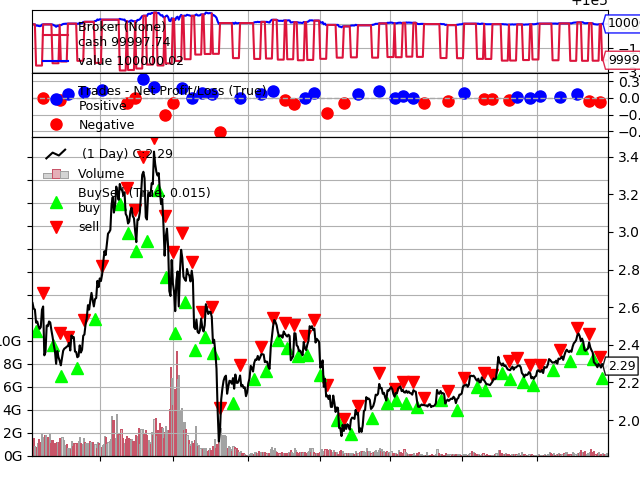

In [4]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import pandas as pd
#bfrom WindPy import w
# Import the backtrader platform
import backtrader as bt
import IPython

# %matplotlib inline
# %matplotlib notebook

# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # To keep track of pending orders
        self.order = None

    def notify(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                # current close less than previous close

                if self.dataclose[-1] < self.dataclose[-2]:
                    # previous close less than the previous close

                    # BUY, BUY, BUY!!! (with default parameters)
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    # Create a Data Feed
    # 本地数据，笔者用Wind获取的东风汽车数据以csv形式存储在本地。
    # parase_dates = True是为了读取csv为dataframe的时候能够自动识别datetime格式的字符串，big作为index
    # 注意，这里最后的pandas要符合backtrader的要求的格式
    dataframe = pd.read_csv('./data/dfqc.csv', index_col=0, parse_dates=True)
    dataframe['openinterest'] = 0
    data = bt.feeds.PandasData(dataname=dataframe,
                        fromdate = datetime.datetime(2015, 1, 1),
                        todate = datetime.datetime(2016, 12, 31)
                        )
    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    # Plot the result
    cerebro.plot()

In [2]:
import backtrader as bt

In [1]:
import backtrader as bt
'''首先引入了backtrader这个包'''
print(dir(bt))
cerebro = bt.Cerebro()
'''实例化Cerebro （大脑）引擎'''
# Cerebro引擎在后台创建了broker(经纪人)实例，系统默认每个broker的初始资金量为10000
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

['AbstractDataBase', 'All', 'Analyzer', 'And', 'Any', 'AutoDictList', 'AutoInfoClass', 'AutoOrderedDict', 'BackBroker', 'BacktraderError', 'BrokerBase', 'BuyOrder', 'CSVDataBase', 'CSVFeedBase', 'Cerebro', 'Cmp', 'CmpEx', 'CommInfoBase', 'CommissionInfo', 'DTFaker', 'DataAccessor', 'DataBase', 'DataClone', 'DataSeries', 'DivByZero', 'DivZeroByZero', 'DotDict', 'FeedBase', 'Filter', 'If', 'Indicator', 'IndicatorBase', 'ItemCollection', 'LineActions', 'LineAlias', 'LineBuffer', 'LineCoupler', 'LineDelay', 'LineIterator', 'LineMultiple', 'LineNum', 'LineOwnOperation', 'LinePlotterIndicator', 'LineRoot', 'LineSeries', 'LineSeriesMaker', 'LineSeriesStub', 'LineSingle', 'Lines', 'LinesCoupler', 'LinesOperation', 'Lines_LineSeries', 'Lines_LineSeries_LineSeriesStub', 'List', 'Logic', 'MAXINT', 'Max', 'MetaAbstractDataBase', 'MetaAnalyzer', 'MetaBroker', 'MetaCSVDataBase', 'MetaIndicator', 'MetaLineActions', 'MetaLineIterator', 'MetaLineSeries', 'MetaObserver', 'MetaParams', 'MetaSigStrategy',

In [1]:
import backtrader as bt
print(f"Backtrader版本：{bt.__version__}")

Backtrader版本：1.9.78.123


In [2]:
from datetime import datetime
import backtrader as bt

class SmaCross(bt.SignalStrategy):
    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=10), bt.ind.SMA(period=30)
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)

cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross)

data0 = bt.feeds.YahooFinanceData(dataname='MSFT', fromdate=datetime(2011, 1, 1),
                                  todate=datetime(2012, 12, 31))
cerebro.adddata(data0)

cerebro.run()
cerebro.plot()

FileNotFoundError: [Errno 2] No such file or directory: 'MSFT'

In [7]:
import streamlit as st
print(st.__version__)
print(dir(st))

1.23.1
['_DeltaGenerator', '_RootContainer', '_STREAMLIT_VERSION_STRING', '_SessionStateProxy', '_UserInfoProxy', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_arrow_altair_chart', '_arrow_area_chart', '_arrow_bar_chart', '_arrow_dataframe', '_arrow_line_chart', '_arrow_table', '_arrow_vega_lite_chart', '_cache', '_cache_data', '_cache_resource', '_column_config', '_config', '_connection_factory', '_experimental_memo', '_experimental_singleton', '_gather_metrics', '_get_query_params', '_legacy_altair_chart', '_legacy_area_chart', '_legacy_bar_chart', '_legacy_dataframe', '_legacy_line_chart', '_legacy_table', '_legacy_vega_lite_chart', '_logger', '_main', '_rerun', '_secrets_singleton', '_set_query_params', '_update_logger', 'altair_chart', 'area_chart', 'audio', 'balloons', 'bar_chart', 'bokeh_chart', 'button', 'cache', 'cache_data', 'cache_resource', 'camera_input', 'caption', 'case_converters', 

In [5]:
# 获取交易日信息
import baostock as bs
import pandas as pd
    
#### 登陆系统 ####
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)
    
#### 获取交易日信息 ####
rs = bs.query_trade_dates(start_date="2024-01-01", end_date="2024-12-31")
print('query_trade_dates respond error_code:'+rs.error_code)
print('query_trade_dates respond  error_msg:'+rs.error_msg)
    
#### 打印结果集 ####
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)
    
#### 结果集输出到csv文件 ####   
result.to_csv("./data/trade_datas2024.csv", encoding="gbk", index=False)
print(result)
    
#### 登出系统 ####
bs.logout()

login success!
login respond error_code:0
login respond  error_msg:success
query_trade_dates respond error_code:0
query_trade_dates respond  error_msg:success
    calendar_date is_trading_day
0      2024-01-01              0
1      2024-01-02              1
2      2024-01-03              1
3      2024-01-04              1
4      2024-01-05              1
..            ...            ...
361    2024-12-27              1
362    2024-12-28              0
363    2024-12-29              0
364    2024-12-30              1
365    2024-12-31              1

[366 rows x 2 columns]
logout success!


In [16]:
dtrg = range(1,13)
print(dtrg)
for i in dtrg:
#     print(i)
    dt = '2024-01-02'
    if i < 10:
        dt = '2024-0'+str(i)+'-02'
    else:
        dt = '2024-'+str(i)+'-02'
    print(dt)

range(1, 13)
2024-01-02
2024-02-02
2024-03-02
2024-04-02
2024-05-02
2024-06-02
2024-07-02
2024-08-02
2024-09-02
2024-10-02
2024-11-02
2024-12-02


In [18]:
import baostock as bs
import pandas as pd
    
# 登陆系统
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code+' error_msg:'+lg.error_msg)

dtrg = range(1,13)
for i in dtrg:
    dt = '2024-01-02'
    if i < 10:
        dt = '2024-0'+str(i)+'-02'
    else:
        dt = '2024-'+str(i)+'-02'
    
    # 获取沪深300成分股
    rs = bs.query_hs300_stocks(date=dt)
    print('query_hs300 error_code:'+rs.error_code+' error_msg:'+rs.error_msg)

    # 打印结果集
    hs300_stocks = []
    while (rs.error_code == '0') & rs.next():
        # 获取一条记录，将记录合并在一起
        hs300_stocks.append(rs.get_row_data())
    result = pd.DataFrame(hs300_stocks, columns=rs.fields)
    # 结果集输出到csv文件
    result.to_csv("./data/hs300_stocks_"+str(i)+".csv", encoding="utf-8", index=False)
#     print(result)
    
# 登出系统
bs.logout()

login success!
login respond error_code:0
login respond  error_msg:success
query_hs300 error_code:0
query_hs300  error_msg:success
query_hs300 error_code:0
query_hs300  error_msg:success
query_hs300 error_code:0
query_hs300  error_msg:success
query_hs300 error_code:0
query_hs300  error_msg:success
query_hs300 error_code:0
query_hs300  error_msg:success
query_hs300 error_code:0
query_hs300  error_msg:success
query_hs300 error_code:0
query_hs300  error_msg:success
query_hs300 error_code:0
query_hs300  error_msg:success
query_hs300 error_code:0
query_hs300  error_msg:success
query_hs300 error_code:0
query_hs300  error_msg:success
query_hs300 error_code:0
query_hs300  error_msg:success
query_hs300 error_code:0
query_hs300  error_msg:success
logout success!


In [25]:
import baostock as bs
import backtrader as bt

print(f"Backtrader版本：{bt.__version__}")

print(dir(bs))
# bs.query_hs300_stocks?
# print(dir(bt.indicators))

Backtrader版本：1.9.78.123
['__author__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'common', 'cons', 'corpreport', 'data', 'evaluation', 'login', 'logout', 'macroscopic', 'metadata', 'query_adjust_factor', 'query_all_stock', 'query_balance_data', 'query_cash_flow_data', 'query_deposit_rate_data', 'query_dividend_data', 'query_dupont_data', 'query_forecast_report', 'query_growth_data', 'query_history_k_data_plus', 'query_hs300_stocks', 'query_loan_rate_data', 'query_money_supply_data_month', 'query_money_supply_data_year', 'query_operation_data', 'query_performance_express_report', 'query_profit_data', 'query_required_reserve_ratio_data', 'query_stock_basic', 'query_stock_industry', 'query_sz50_stocks', 'query_trade_dates', 'query_zz500_stocks', 'security', 'util']


In [23]:
import pandas as pd
import baostock as bs


def query_history_k_data_plus(stock_code: str):
    
    #### 获取沪深A股历史K线数据 ####
    # 详细指标参数，参见“历史行情指标参数”章节；“分钟线”参数与“日线”参数不同。“分钟线”不包含指数。
    # 分钟线指标：date,time,code,open,high,low,close,volume,amount,adjustflag
    # 周月线指标：date,code,open,high,low,close,volume,amount,adjustflag,turn,pctChg
    rs = bs.query_history_k_data_plus(stock_code,
        "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST,peTTM,psTTM,pcfNcfTTM,pbMRQ",
        start_date='2024-01-01', end_date='2024-12-31',
        frequency="d", adjustflag="3")
    print('query_history_k_data_plus respond error_code:'+rs.error_code+' error_msg:'+rs.error_msg)
    
    #### 打印结果集 ####
    data_list = []
    while (rs.error_code == '0') & rs.next():
        # 获取一条记录，将记录合并在一起
        data_list.append(rs.get_row_data())
    result = pd.DataFrame(data_list, columns=rs.fields)
    
    #### 结果集输出到csv文件 ####   
    result.to_csv("./data/history_A_stock_k_data"+stock_code+".csv", index=False)
    
    
    

df = pd.read_csv('./data/hs300_stocks.csv', encoding="utf-8")
# df = df.dropna() # 删除包含NaN的行
# df = df.fillna(0) # 用0填充所有缺失的值
# df = pd.read_csv('your_file.csv', usecols=['column1', 'column2']) 只想读取文件中的某些列，可以通过`usecols`参数来选择：
# dt.groupby('code')['code_name'].count()
# 使用iterrows()或itertuples()

#### 登陆系统 ####
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code+' error_msg:'+lg.error_msg)
    
for index,row in df.iterrows():
    # print(index)
    # print(row["code"]+"\t"+row["code_name"])
    if index < 5:
        query_history_k_data_plus(row["code"])
    
#### 登出系统 ####
bs.logout()


login success!
login respond error_code:0 error_msg:success
query_history_k_data_plus respond error_code:0 error_msg:success
query_history_k_data_plus respond error_code:0 error_msg:success
query_history_k_data_plus respond error_code:0 error_msg:success
query_history_k_data_plus respond error_code:0 error_msg:success
query_history_k_data_plus respond error_code:0 error_msg:success
logout success!


In [54]:
%matplotlib inline   
#先引入后面可能用到的包（package）
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import backtrader as bt
 
#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

# 简单的单均线策略,当收盘价上涨突破5日均线买入（做多），当收盘价下跌跌穿5日均线卖出（做空）
class SmaStrategy(bt.Strategy):
    params=(('maperiod',12),
            ('printlog',True),)
    def __init__(self):
        #指定价格序列
        self.dataclose=self.datas[0].close
        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buyprice = None
        self.buycomm = None
        # This would for example allow to create a Sizer at the same level as the cerebro calls are happening and pass it as a parameter 
        # to all strategies that go in the system, which effectevily allows sharing a Sizer
        print(self.p.sizer)
        if self.p.sizer is not None:
            self.sizer = self.p.sizer
        #添加移动均线指标
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.maperiod)
    #策略核心，根据条件执行买卖交易指令（必选）
    def next(self):
        # 记录收盘价
        self.log(f'收盘价, {self.dataclose[0]}')
        if self.order: # 检查是否有指令等待执行, 
            return
        # 检查是否持仓   
        if not self.position: # 没有持仓
            #执行买入条件判断：收盘价格上涨突破15日均线
            if self.dataclose[0] > self.sma[0]:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                #执行买入
                self.order = self.buy()         
        else:
            #执行卖出条件判断：收盘价格跌破15日均线
            if self.dataclose[0] < self.sma[0]:
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                #执行卖出
                self.order = self.sell()
    #交易记录日志（可省略，默认不输出结果）
    def log(self, txt, dt=None,doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()},{txt}')
    #记录交易执行情况（可省略，默认不输出结果）
    def notify_order(self, order):
        # 如果order为submitted/accepted,返回空
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 如果order为buy/sell executed,报告价格结果
        if order.status in [order.Completed]: 
            if order.isbuy():
                self.log(f'买入:\n价格:{order.executed.price},\
                成本:{order.executed.value},\
                手续费:{order.executed.comm}')
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(f'卖出:\n价格：{order.executed.price},\
                成本: {order.executed.value},\
                手续费{order.executed.comm}')
            self.bar_executed = len(self) 
        # 如果指令取消/交易失败, 报告结果
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失败')
        self.order = None
    #记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        self.log(f'策略收益：\n毛收益 {trade.pnl:.2f}, 净收益 {trade.pnlcomm:.2f}')
    #回测结束后输出结果（可省略，默认输出结果）
    def stop(self):
        self.log('(MA均线： %2d日) 期末总资金 %.2f' %(self.params.maperiod, self.broker.getvalue()), doprint=True)

# 打板策略,当日收盘价涨停时买入（做多），当收盘价下跌超5%卖出（做空）
class UpperStrategy(bt.Strategy):
    params=(('maperiod',5),
            ('printlog',True),)
    def __init__(self):
        #指定价格序列
        self.dataclose=self.datas[0].close
        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buyprice = None
        self.buycomm = None
#         if self.p.sizer is not None:
#             self.sizer = self.p.sizer
        #添加移动均线指标
        # self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.maperiod)
    #策略核心，根据条件执行买卖交易指令（必选）连续三日上涨或是前一日的10%及以上
    def next(self):
        # 记录收盘价
        self.log(f'收盘价, {self.dataclose[0]}')
        if self.order: # 检查是否有指令等待执行, 
            return
        # 检查是否持仓
        print("现金："+str(self.broker.getcash())+" 买需要的钱:"+str(10000*self.dataclose[0]))
        # 没有持仓 self.p.sizer.stake
        if ((not self.position) or (self.broker.getcash() >= 10000*self.dataclose[0])): 
            #执行买入条件判断：收盘价格上涨突破15日均线
            print("self.dataclose[0]"+str(self.dataclose[0])+"self.dataclose[-1]"+str(self.dataclose[-1])+" "+str(self.dataclose[0] > self.dataclose[-1]))
            print("self.dataclose[-1]"+str(self.dataclose[-1])+"self.dataclose[-2]"+str(self.dataclose[-2])+" "+str(self.dataclose[-1] > self.dataclose[-2]))
            if self.dataclose[0] > self.dataclose[-1]:
                if self.dataclose[-1] > self.dataclose[-2]:
                    self.log('BUY CREATE 3 UP, %.2f' % self.dataclose[0])
                    #执行买入
                    self.order = self.buy()    
            elif self.dataclose[0] >= (self.dataclose[-1]*110/100):
                self.log('BUY CREATE UPPER, %.2f' % self.dataclose[0])
                #执行买入
                self.order = self.buy()
            else:
                print("buy nothing but sell.......")
                print("卖出条件判断："+str(self.dataclose[0]/self.dataclose[-1])+"%")
                if self.position and ((self.dataclose[0] <= (self.dataclose[-1]*95/100)) or (self.dataclose[0] <= (self.dataclose[-2]*95/100)) or (self.dataclose[0] <= (self.dataclose[-3]*95/100))):
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    #执行卖出
                    self.order = self.sell()
        else:
            #执行卖出条件判断：收盘价格跌破15日均线
            print("卖出条件判断："+str(self.dataclose[0]/self.dataclose[-1])+"%"+" or "+str(self.dataclose[0]/(self.dataclose[-2]))+"%")
            if ((self.dataclose[0] <= (self.dataclose[-1]*95/100)) or (self.dataclose[0] <= (self.dataclose[-2]*95/100)) or (self.dataclose[0] <= (self.dataclose[-3]*95/100))):
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                #执行卖出
                self.order = self.sell()
    #交易记录日志（可省略，默认不输出结果）
    def log(self, txt, dt=None,doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()},{txt}')
    #记录交易执行情况（可省略，默认不输出结果）
    def notify_order(self, order):
        # 如果order为submitted/accepted,返回空
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 如果order为buy/sell executed,报告价格结果
        if order.status in [order.Completed]: 
            if order.isbuy():
                self.log(f'买入: 价格:{order.executed.price},\
                成本:{order.executed.value},\
                手续费:{order.executed.comm}')
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(f'卖出: 价格：{order.executed.price},\
                成本: {order.executed.value},\
                手续费{order.executed.comm}')
            self.bar_executed = len(self) 
        # 如果指令取消/交易失败, 报告结果
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失败')
        self.order = None
    #记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        self.log(f'策略收益：毛收益 {trade.pnl:.2f}, 净收益 {trade.pnlcomm:.2f}')
    #回测结束后输出结果（可省略，默认输出结果）
    def stop(self):
        self.log('(MA均线： %2d日) 期末总资金 %.2f' %(self.params.maperiod, self.broker.getvalue()), doprint=True)
        

def run_trade_sma(code,start,end='',startcash=10000,qts=1000,com=0.0001):
    """
    下面定义一个主函数，用于对某股票指数（个股）在指定期间进行回测，使用下载好的baostock数据，
    包含开盘价、最高价、最低价、收盘价和成交量。这里主要以3到30日均线为例进行参数寻优，
    考察以多少日均线与价格的交叉作为买卖信号能获得最大的收益。
    """
    #创建主控制器
    cerebro = bt.Cerebro()      
    #导入策略参数寻优 range(3, 31)
    #  cerebro.optstrategy(Sma5Strategy,maperiod=5)    
    #获取数据
    df = pd.read_csv('./data/k_data_'+code+'.csv', encoding="utf-8")
    df.index = pd.to_datetime(df.date)
    df = df[['open','high','low','close','volume']]
    #将数据加载至回测系统
    data = bt.feeds.PandasData(dataname=df)    
    cerebro.adddata(data)
    idx = cerebro.addstrategy(SmaStrategy,maperiod=12)
    #设置默认所有策略都用的买入设置，策略，数量
    cerebro.addsizer(bt.sizers.FixedSize, stake=qts)   
    # specify size to a strategy
    # cerebro.addsizer_byidx(idx, bt.sizers.SizerFix, stake=qts)
    # 可以同时执行多个策略
    #cerebro.addstrategy(SmaStrategy,maperiod=12)
    #broker设置资金、手续费
    cerebro.broker.setcash(startcash)           
    cerebro.broker.setcommission(commission=com)  
    print('期初总资金: %.2f' %                    
    cerebro.broker.getvalue())    
    cerebro.run(maxcpus=1)    
    print('期末总资金: %.2f' % cerebro.broker.getvalue())
    cerebro.plot()
    print(cerebro.datas)
    print(dir(cerebro))

def run_trade_upper(code,start,end='',startcash=10000,qts=1000,com=0.0001):
    """
    下面定义一个主函数，用于对某股票指数（个股）在指定期间进行回测，使用下载好的baostock数据，
    包含开盘价、最高价、最低价、收盘价和成交量。这里主要以3到30日均线为例进行参数寻优，
    考察以多少日均线与价格的交叉作为买卖信号能获得最大的收益。
    """
    #创建主控制器
    cerebro1 = bt.Cerebro()      
    #导入策略参数寻优 range(3, 31)
    # cerebro.optstrategy(Sma5Strategy,maperiod=5)    
    #获取数据
    df = pd.read_csv('./data/k_data_'+code+'.csv', encoding="utf-8")
    df.index = pd.to_datetime(df.date)
    df = df[['open','high','low','close','volume']]
    #将数据加载至回测系统
    data = bt.feeds.PandasData(dataname=df)    
    cerebro1.adddata(data)
    idx = cerebro1.addstrategy(UpperStrategy,maperiod=12)
    #设置默认所有策略都用的买入设置，策略，数量
    cerebro1.addsizer(bt.sizers.FixedSize, stake=qts)   
    # specify size to a strategy
    # cerebro.addsizer_byidx(idx, bt.sizers.SizerFix, stake=qts)
    # 可以同时执行多个策略
    #cerebro.addstrategy(SmaStrategy,maperiod=12)
    #broker设置资金、手续费
    cerebro1.broker.setcash(startcash)           
    cerebro1.broker.setcommission(commission=com)  
    print('期初总资金: %.2f' %                    
    cerebro1.broker.getvalue())    
    cerebro1.run(maxcpus=1)    
    print('期末总资金: %.2f' % cerebro1.broker.getvalue())
    cerebro1.plot()
    #print(cerebro1.datas)
    #print(dir(cerebro1))

def plot_stock(code,title,start,end):
    """
    再定义一个画图函数，对相应股票（指数）在某期间的价格走势和累计收益进行可视化。
    """
    df = pd.read_csv('./data/k_data_'+code+'.csv', encoding="utf-8")
#     dd=ts.get_k_data(code,autype='qfq',start=start,end=end)
#     print(df.index)
    df.index = pd.to_datetime(df.date)
    print(str(df.index[1])+"  "+str(df.index[-100])+" "+str(df.close.max()))
    df.close.plot(figsize=(14,6),color='r')
    plt.title(title+'价格走势\n'+start+' to '+end,size=15)
    # s：代表标注的内容，xy：需要被标注的坐标，通过xycoords设置偏移方式，
    # xytext：标注的文字的坐标，通过textcoords设置偏移方式、xycoords：用于设置xy的偏移方式
    plt.annotate(f'期间累计涨幅:{(df.close[-1]/df.close[0]-1)*100:.2f}%', xy=(df.index[-1],df.close.max()-0.2), 
             xytext=(df.index[-1],df.close.min()), bbox = dict(boxstyle = 'round,pad=0.5',
            fc = 'yellow', alpha = 0.5),
             arrowprops=dict(facecolor='green', shrink=0.05),fontsize=12)
    plt.show()

2024-01-03 00:00:00  2024-08-05 00:00:00 10.5


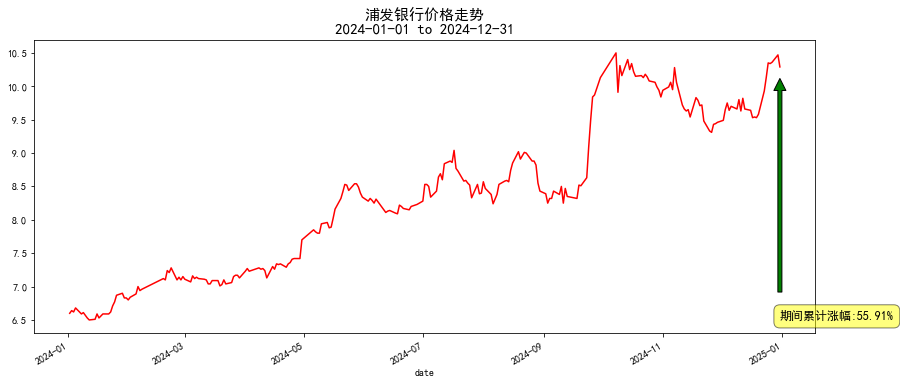

In [4]:
# 以上证综指为例，回测期间为2010-01-01至2020-03-30，期间累计收益率为-15.31%，惨不忍睹。
plot_stock('sh.600000','浦发银行','2024-01-01','2024-12-31')

期初总资金: 1000000.00
2024-01-17,收盘价, 6.53
2024-01-18,收盘价, 6.56
2024-01-19,收盘价, 6.59
2024-01-19,BUY CREATE, 6.59
2024-01-22,买入:
价格:6.58,                成本:6580.0,                手续费:0.658
2024-01-22,收盘价, 6.59
2024-01-23,收盘价, 6.62
2024-01-24,收盘价, 6.71
2024-01-25,收盘价, 6.77
2024-01-26,收盘价, 6.87
2024-01-29,收盘价, 6.9
2024-01-30,收盘价, 6.83
2024-01-31,收盘价, 6.83
2024-02-01,收盘价, 6.8
2024-02-02,收盘价, 6.84
2024-02-05,收盘价, 6.89
2024-02-06,收盘价, 7.0
2024-02-07,收盘价, 6.94
2024-02-08,收盘价, 6.96
2024-02-19,收盘价, 7.12
2024-02-20,收盘价, 7.1
2024-02-21,收盘价, 7.24
2024-02-22,收盘价, 7.21
2024-02-23,收盘价, 7.28
2024-02-26,收盘价, 7.1
2024-02-27,收盘价, 7.14
2024-02-28,收盘价, 7.1
2024-02-29,收盘价, 7.15
2024-03-01,收盘价, 7.11
2024-03-01,SELL CREATE, 7.11
2024-03-04,卖出:
价格：7.12,                成本: 6580.0,                手续费0.7120000000000001
2024-03-04,策略收益：
毛收益 540.00, 净收益 538.63
2024-03-04,收盘价, 7.07
2024-03-05,收盘价, 7.16
2024-03-05,BUY CREATE, 7.16
2024-03-06,买入:
价格:7.17,                成本:7170.0,                手续费:0.7170000000000001
202

<IPython.core.display.Javascript object>


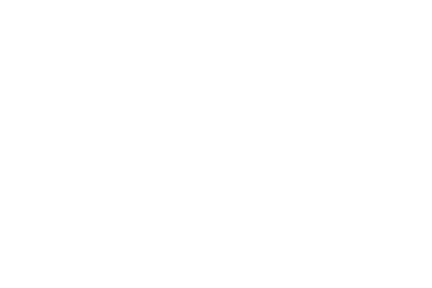

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_timer', '_broker', '_brokernotify', '_check_timers', '_dataid', '_datanotify', '_disable_runonce', '_dolive', '_dooptimize', '_dopreload', '_doreplay', '_dorunonce', '_event_stop', '_exactbars', '_fhistory', '_init_stcount', '_next_stid', '_next_writers', '_notify_data', '_notify_store', '_ohistory', '_pretimers', '_runnext', '_runnext_old', '_runonce', '_runonce_old', '_signal_accumulate', '_signal_concurrent', '_signal_strat', '_storenotify', '_timers', '_timerscheat', '_tradingcal', 'add_order_history', 'add_signal', 'add_timer', 'addanalyzer', 'addcalendar', 'adddata', 'adddatacb', 'addindicator', 'addobserver

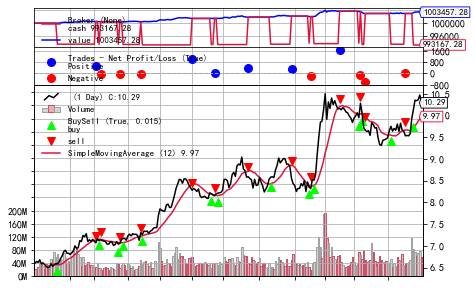

In [5]:
# 下面分别对3-30日均线进行回测，这里假设指数可以交易，初始资金为100万元，每次交易100股，
# 注意如果指数收盘价乘以100超过可用资金，会出现交易失败的情况，
# 换句话说在整个交易过程中，是交易固定数量的标的，因此仓位的大小跟股价有直接关系。
run_trade_sma('sh.600000','2024-01-01','2024-12-31',1000000,1000)

期初总资金: 1000000.00
2024-01-02,收盘价, 6.6
现金：1000000.0 买需要的钱:66000.0
self.dataclose[0]6.6self.dataclose[-1]10.29 False
self.dataclose[-1]10.29self.dataclose[-2]10.47 False
buy nothing but sell.......
卖出条件判断：0.641399416909621%
2024-01-03,收盘价, 6.64
现金：1000000.0 买需要的钱:66400.0
self.dataclose[0]6.64self.dataclose[-1]6.6 True
self.dataclose[-1]6.6self.dataclose[-2]10.29 False
2024-01-04,收盘价, 6.62
现金：1000000.0 买需要的钱:66200.0
self.dataclose[0]6.62self.dataclose[-1]6.64 False
self.dataclose[-1]6.64self.dataclose[-2]6.6 True
buy nothing but sell.......
卖出条件判断：0.996987951807229%
2024-01-05,收盘价, 6.68
现金：1000000.0 买需要的钱:66800.0
self.dataclose[0]6.68self.dataclose[-1]6.62 True
self.dataclose[-1]6.62self.dataclose[-2]6.64 False
2024-01-08,收盘价, 6.59
现金：1000000.0 买需要的钱:65900.0
self.dataclose[0]6.59self.dataclose[-1]6.68 False
self.dataclose[-1]6.68self.dataclose[-2]6.62 True
buy nothing but sell.......
卖出条件判断：0.9865269461077845%
2024-01-09,收盘价, 6.61
现金：1000000.0 买需要的钱:66100.0
self.dataclose[0]6.61self.datac

2024-08-12,收盘价, 8.58
现金：26085.38 买需要的钱:85800.0
卖出条件判断：1.0058616647127785% or 1.0238663484486872%
2024-08-13,收盘价, 8.59
现金：26085.38 买需要的钱:85900.0
卖出条件判断：1.0011655011655012% or 1.0070339976553342%
2024-08-14,收盘价, 8.57
现金：26085.38 买需要的钱:85700.0
卖出条件判断：0.9976717112922003% or 0.9988344988344988%
2024-08-15,收盘价, 8.74
现金：26085.38 买需要的钱:87400.0
卖出条件判断：1.0198366394399065% or 1.0174621653084983%
2024-08-16,收盘价, 8.85
现金：26085.38 买需要的钱:88500.0
卖出条件判断：1.0125858123569793% or 1.0326721120186697%
2024-08-19,收盘价, 9.02
现金：26085.38 买需要的钱:90200.0
卖出条件判断：1.0192090395480227% or 1.032036613272311%
2024-08-20,收盘价, 8.91
现金：26085.38 买需要的钱:89100.0
卖出条件判断：0.9878048780487806% or 1.0067796610169493%
2024-08-21,收盘价, 8.96
现金：26085.38 买需要的钱:89600.00000000001
卖出条件判断：1.005611672278339% or 0.993348115299335%
2024-08-22,收盘价, 9.01
现金：26085.38 买需要的钱:90100.0
卖出条件判断：1.005580357142857% or 1.0112233445566778%
2024-08-23,收盘价, 9.0
现金：26085.38 买需要的钱:90000.0
卖出条件判断：0.9988901220865705% or 1.0044642857142856%
2024-08-26,收盘价, 8.88
现金：2

<IPython.core.display.Javascript object>


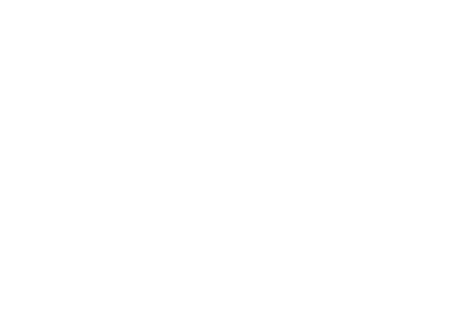

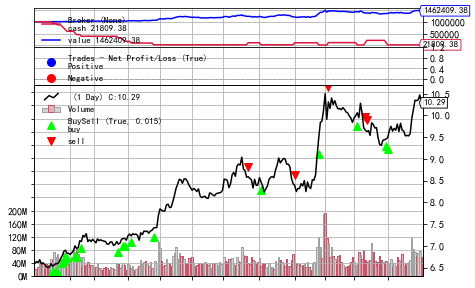

In [55]:
run_trade_upper('sh.600000','2024-01-01','2024-12-31',1000000,10000)